# Tree-based model forecasting a time series with trend

In this notebook we will show how we can use tree-based models when the time series contains trend. We will introduce some useful transformers in `sktime` that allow us to create a simple forecast to de-trend our data. We will then use this in the context of a recursive forecasting example.

In [1]:
import datetime

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

sns.set_context("talk")

# Data set synopsis

The air passengers dataset is the monthly totals of international airline passengers, from 1949 to 1960, in units of 1000s. 

For instructions on how to download, prepare, and store the dataset, refer to notebook number 5, in the folder "01-Create-Datasets" from this repo.

In [2]:
data = pd.read_csv(
    "../Datasets/example_air_passengers.csv",
    parse_dates=["ds"],
    index_col=["ds"],
)

## Plot the data

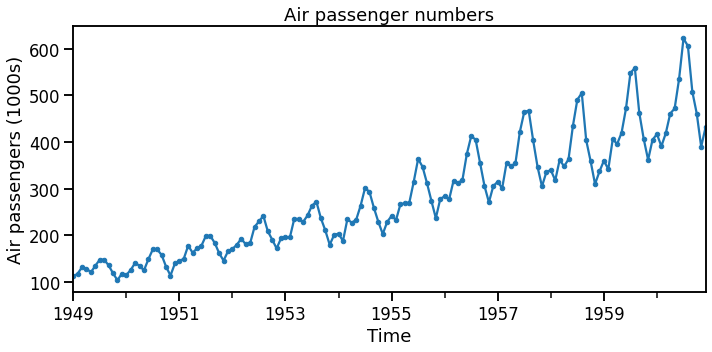

In [3]:
fig, ax = plt.subplots(figsize=[10, 5])
data.plot(y="y", marker=".", legend=None, ax=ax)
ax.set_xlabel("Time")
ax.set_ylabel("Air passengers (1000s)")
ax.set_title("Air passenger numbers")
plt.tight_layout()

# sktime trend forecasters

We will need the trend during the training period and the forecasting horizon (i.e., the testing period). 

So we need to be able to extract the trend in the training period and also project it into the future.

Let's use an `sktime` forecaster to model a polynomial trend:

$$T_t = \beta_0 + \beta_1t + \beta_2t^2 + ... + \beta_dt^d$$

where $d$ is the degree of the polynomial and $t$ is time.

In [4]:
from sktime.forecasting.trend import PolynomialTrendForecaster  # An sktime forecaster.
                                                                # Forecasters have a `fit` and `predict` method.

In [5]:
# Create a copy of the data
df = data.copy().asfreq("MS") # Need to explictly 
                              # have the `freq` set
                              # for PolynomialTrendForecaster
df.head()

,y
ds,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [6]:
trend_forecaster = PolynomialTrendForecaster(degree=1)  # Polynomial degree of `t`

# Fit the forecaster on a time series
trend_forecaster.fit(y=df[["y"]])

# Define the forecasting horizon
fh = pd.date_range(
                   start=df.index.min(), 
                   end=df.index.max() + pd.DateOffset(months=12), 
                   freq="MS"
                  )

trend = trend_forecaster.predict(fh=fh)  # Forecasting horizon.
                                         # Get forecast over this period.

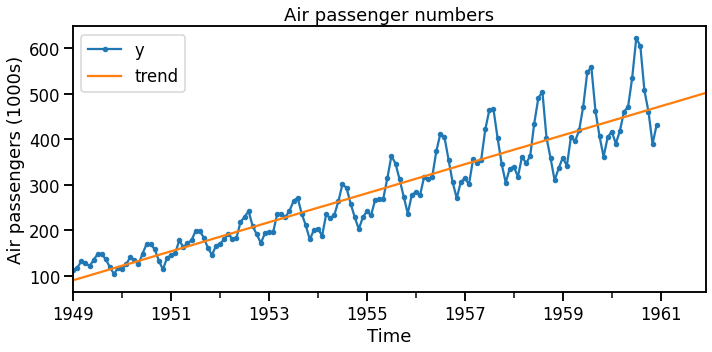

In [7]:
# Plot trend and time series
fig, ax = plt.subplots(figsize=[10, 5])
data.plot(y="y", marker=".", legend=None, ax=ax)
trend.plot(ax=ax)
ax.legend(["y", "trend"])
ax.set_xlabel("Time")
ax.set_ylabel("Air passengers (1000s)")
ax.set_title("Air passenger numbers")
plt.tight_layout()

Let's try de-trending the data we by subtracting $y$ by the `trend`.

In [8]:
df["y_detrended"] = df[["y"]] - trend

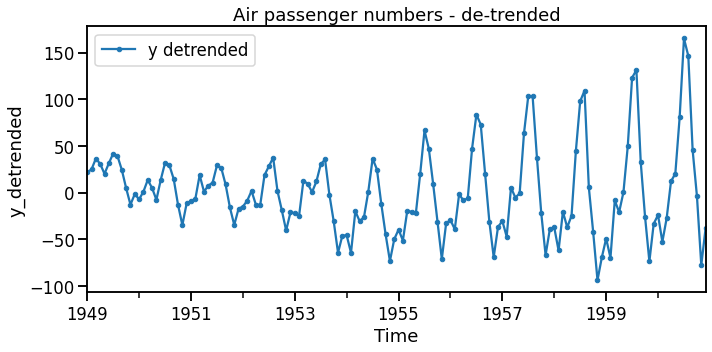

In [9]:
# Plot de-trended time series
fig, ax = plt.subplots(figsize=[10, 5])
df.plot(y="y_detrended", marker=".", legend=None, ax=ax)
ax.legend(["y detrended"])
ax.set_xlabel("Time")
ax.set_ylabel("y_detrended")
ax.set_title("Air passenger numbers - de-trended")
plt.tight_layout()

The seasonal variation still increases quite a lot with time here. We notice that the  original time series looks multiplicative (the seasonal variation increases with the level of the time series). We'll introduce the `LogTransformer` from sktime to take the logarithm of this series to make it look more additive. 

In [10]:
from sktime.transformations.series.boxcox import LogTransformer

In [11]:
log_trafo = LogTransformer()
df["y"] = log_trafo.fit_transform(df[["y"]])

Let's re-fit the trend forecaster.

In [12]:
# Fit the forecaster on a time series
trend_forecaster.fit(y=df["y"])

# Define the time horizon over which we want to compute the trend
fh = pd.date_range(
                   start=df.index.min(), 
                   end=df.index.max() + pd.DateOffset(months=12), 
                   freq="MS"
                  )

trend = trend_forecaster.predict(fh=fh)  # Forecasting horizon.
                                         # Get forecast over this period.

In [13]:
df["y_detrended"] = df["y"] - trend

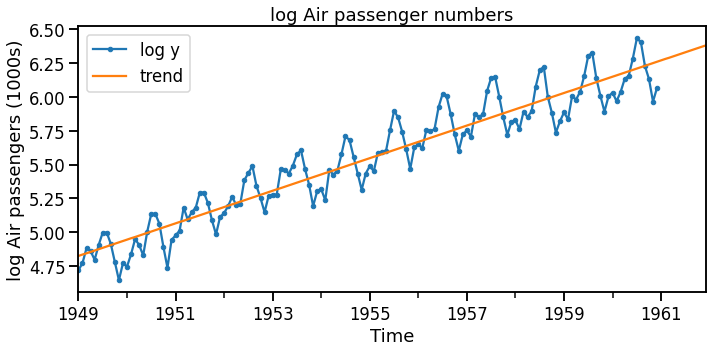

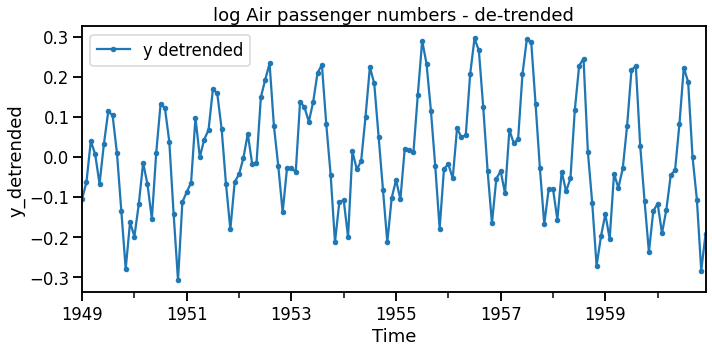

In [14]:
# Plot trend and time series
fig, ax = plt.subplots(figsize=[10, 5])
df.plot(y="y", marker=".", legend=None, ax=ax)
trend.plot(ax=ax)
ax.legend(["log y", "trend"])
ax.set_xlabel("Time")
ax.set_ylabel("log Air passengers (1000s)")
ax.set_title("log Air passenger numbers")
plt.tight_layout()

# Plot de-trended time series
fig, ax = plt.subplots(figsize=[10, 5])
df.plot(y="y_detrended", marker=".", legend=None, ax=ax)
ax.legend(["y detrended"])
ax.set_xlabel("Time")
ax.set_ylabel("y_detrended")
ax.set_title("log Air passenger numbers - de-trended")
plt.tight_layout()

This will be a lot easier for a tree-based model to handle because the values that the tree needs to predict lie within the range of y values seen in the plot.

After forecasting the de-trended time series we will add back the `trend`. 

sktime has a convenient transformer that allows us to de-trend and add the trend back called `Detrender`.

In [15]:
from sktime.transformations.series.detrend import Detrender

We can pass any forecasting method, such as `PolynomialTrendForecaster` to de-trend our time series.

In [16]:
detrender = Detrender(forecaster=PolynomialTrendForecaster(degree=1))

Note: the default value for for `forecaster` in `Dentrender` is `PolynomialTrendForecaster(degree=1)`. So we could also just write `detrender = Detrender()` above if we wanted to.

In [17]:
# Fit our de-trender on any segment of historical data
detrender.fit(df.loc[:"1955-01-01", ["y"]])  # Fits the polynomial trend forecaster
                                           # to the data.

# De-trend time series from any time period with our de-trender
y_detrended = detrender.transform(df.loc["1955-02-01":, ["y"]])  # Calculates trend
                                                            # over the time range
                                                            # of the input dataframe
                                                            # and subtracts it
                                                            # from the input.

# Add trend back to our time series from any time period
y_w_trend = detrender.inverse_transform(y_detrended)  # Calculates trend
                                                    # over the time range
                                                    # of the input dataframe
                                                    # and adds it back
                                                    # to the input.

In [18]:
# Sanity check that adding the trend back recovered
# our original time series.
all(df.loc["1955-02-01":, ["y"]] == y_w_trend)

True

So with `PolynomialTrendForecaster` and `Detrender` we have a way of fitting a trend to the time series the past and the future. `Detrender` gives us a transformer that allows us to fit the trend and then de-trend the training data via `fit` and `transform`; we can then add the trend back to our de-trended forecasts via `inverse_transform`.

We can do both the log transform and detrending in a single pipeline.

In [19]:
from sklearn.pipeline import make_pipeline

In [20]:
# Make a pipeline of transformations
# to the target variable
target_trafo = make_pipeline(
    log_trafo, # First apply log transform.
    detrender, # Then de-trend the time series.
)

In [21]:
# Create a copy of the data
df = data.copy().asfreq("MS")
df.head()

,y
ds,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [22]:
# Fit our target transformer on historical data.
target_trafo.fit(df.loc[:"1955-01-01", ["y"]])

# Apply log and de-trend time series from any time period with our transformer
y_transformed = target_trafo.transform(df.loc["1955-02-01":, ["y"]])

# Add trend back and apply inverse log to our time series.
y_inv_transformed = target_trafo.inverse_transform(y_transformed)

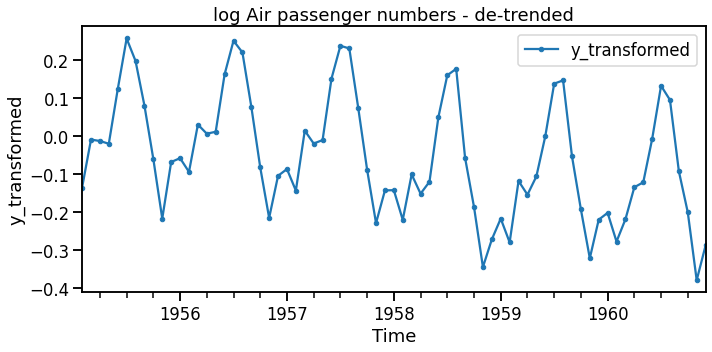

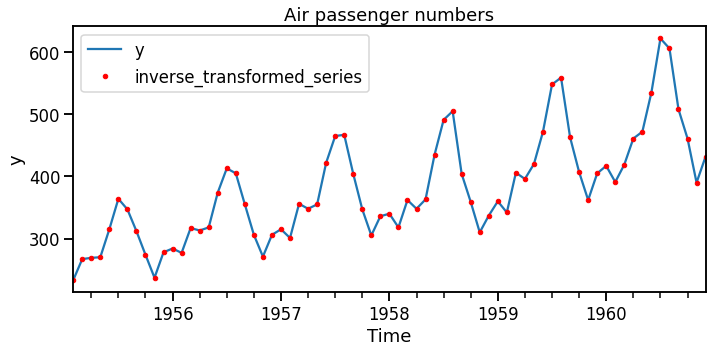

In [23]:
# Plot transformed time series
fig, ax = plt.subplots(figsize=[10, 5])
y_transformed.plot(marker=".", legend=None, ax=ax)
ax.legend(["y_transformed"])
ax.set_xlabel("Time")
ax.set_ylabel("y_transformed")
ax.set_title("log Air passenger numbers - de-trended")
plt.tight_layout()

# Plot original series and inverse transformed series
fig, ax = plt.subplots(figsize=[10, 5])
df.loc["1955-02-01":, "y"].plot(ax=ax)
y_inv_transformed.plot(marker=".", linestyle="none", color="r", ax=ax)
ax.legend(["y", "inverse_transformed_series"])
ax.set_xlabel("Time")
ax.set_ylabel("y")
ax.set_title("Air passenger numbers")
plt.tight_layout()

As you can see the pipeline does exactly what we want - it can apply our transforms (log, de-trend) and then invert them on future data (add trend, invert log).

 Let's move onto forecasting with tree based models.

# Let's build some forecasts with tree based models!

 Let's build a recursive forecast and see how we can add de-trending and re-trending to our workflow.

In [24]:
# Let's ensure all sklearn transformers output pandas dataframes
from sklearn import set_config
from sklearn.base import clone
from sklearn.pipeline import make_pipeline, make_union
from sklearn.preprocessing import PolynomialFeatures
from sktime.transformations.series.summarize import WindowSummarizer
from sktime.transformations.series.time_since import TimeSince
from sktime.transformations.series.detrend import Detrender

# Import models
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor

set_config(transform_output="pandas")  # Upgrade to scikit-learn 0.12
                                       # for this feature

In [25]:
# Create a copy of the data
df = data.copy().asfreq("MS")
df.head()

,y
ds,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [26]:
target = ["y"]  # Note: it's in a list.
                # This ensures we'll get
                # a dataframe when using df.loc[:, target]
                # rather than a pandas Series.
                # This can also be useful if we have
                # multiple targets.

Prepare our transformers. 

Let's start with the transformations to the target variable that we want to do before hand (apply log, de-trend) and then invert the transformations at the end (add the trend back, take inverse log).

In [27]:
# Log transformer
log_trafo = LogTransformer()

# Detrender
detrender = Detrender()

# Make a pipeline of transformations
# to the target variable
target_trafo = make_pipeline(
    log_trafo,
    detrender,
)

We will still build the time feature. This is because it would still allow a tree based model to segment over time and isolate changepoints, outliers, and other interesting periods during training.

In [28]:
# Prepare time feature transformer.
time_feats = TimeSince()

Create lag and window features transformer.

In [29]:
# Features computed from the target.
# Compute lag and window features.
lag_window_feats = WindowSummarizer(
    lag_feature={
        "lag": [1, 2, 3, 12],  # Lag features.
        "mean": [[1, 12]],  # [[lag, window size]]
    },
    target_cols=target,
    truncate="bfill",  # Backfill missing values from lagging and windowing.
)

Create a pipeline to create all our features from the de-trended time series.

In [30]:
# Create features derived independent of one another
pipeline = make_union(time_feats, lag_window_feats)

Let's check how our feature engineering pipeline behaves.

In [31]:
pipeline.fit_transform(df)

,time_since_1949-01-01 00:00:00,y_lag_1,y_lag_2,y_lag_3,y_lag_12,y_mean_1_12
ds,,,,,,
1949-01-01,0,112.0,112.0,112.0,112.0,126.166667
1949-02-01,1,112.0,112.0,112.0,112.0,126.166667
1949-03-01,2,118.0,112.0,112.0,112.0,126.166667
1949-04-01,3,132.0,118.0,112.0,112.0,126.166667
1949-05-01,4,129.0,132.0,118.0,112.0,126.166667
...,...,...,...,...,...,...
1960-08-01,139,622.0,535.0,472.0,559.0,459.416667
1960-09-01,140,606.0,622.0,535.0,463.0,463.333333
1960-10-01,141,508.0,606.0,622.0,407.0,467.083333


Let's reset our feature engineering pipeline.

In [32]:
# We can use `clone` to return an unfitted version
# of the pipeline.
pipeline = clone(pipeline)

Let's build a recursive forecast.

In [33]:
# --- CONFIG --- #
# Define time of first forecast, this determines our train / test split
forecast_start_time = pd.to_datetime("1958-01-01")

# Define number of steps to forecast.
num_of_forecast_steps = 36

# Define the model.
model = DecisionTreeRegressor()

# Create a list of periods that we'll forecast over.
forecast_horizon = pd.date_range(
    forecast_start_time, periods=num_of_forecast_steps, freq="MS"
)

# How much data in the past is needed to create our features
look_back_window_size = pd.DateOffset(months=12)  # We need the latest 12 time periods
                                                  # in our predict dataframe to build our
                                                  # window features.

# --- CREATE TRAINING & TESTING DATAFRAME  --- #
# Ensure we only have training data up to the start
# of the forecast.
df_train = df.loc[df.index < forecast_start_time].copy()
df_test = df.loc[df.index >= forecast_start_time].copy()

# --- !NEW CODE BLOCK! ---#
# --- TRAIN DETRENDER AND DETREND ---#
df_train[target] = target_trafo.fit_transform(df_train[target])
df_test[target] = target_trafo.transform(df_test[target])

# --- FEATURE ENGINEERING--- #
# Create X_train and y_train
y_train = df_train[target]
X_train = pipeline.fit_transform(df_train)

# --- MODEL TRAINING---#
# Train one-step ahead forecast model
model.fit(X_train, y_train)

# --- CREATE DYNAMIC PREDICTION DATAFRAME  --- #
# We will recursively append our forecasts to this
# dataframe and re-compute our lag and window features from the
# target in this dataframe. It contains data in both the training period
# and forecast period which is needed for some transformers (e.g., lags and windows).
look_back_start_time = forecast_start_time - look_back_window_size

# Create `df_predict` which has data going as far back
# as needed to create features which need past values.
df_predict = df_train.loc[look_back_start_time:].copy()

# Extend index into forecast horizon
df_predict = pd.concat([df_predict, pd.DataFrame(index=forecast_horizon)])

# Set the target variable at the forecast start time
# and beyond.
df_predict.loc[forecast_start_time:, target] = np.NaN

# --- RECURSIVE FORECASTING LOOP --- #
for forecast_time in forecast_horizon:
    # Compute features during the forecast horizon
    X_test = pipeline.transform(df_predict)
    X_test_ = X_test.loc[[forecast_time]]

    # Predict one step ahead.
    y_pred = model.predict(X_test_)

    # Append forecast to the target variable columnn in our
    # dynamic forecast dataframe `df_forecast`. This `df_forecast`
    # is ready for the next iteration where we will re-compute
    # features derived from the target such as lags and windows.
    df_predict.loc[[forecast_time], target] = y_pred

# --- GET FORECAST AND TEST VALUES --- #
y_forecast = df_predict.loc[forecast_horizon, target]
y_test = df_test.loc[forecast_start_time:, target]

In [34]:
# --- CREATE IN-SAMPLE PREDICTIONS--- #
y_forecast_train = model.predict(X_train)
y_forecast_train = pd.DataFrame(y_forecast_train, index=X_train.index, columns=target)

In [35]:
# --- ADD TREND BACK AND APPLY INVERSE LOG TRANSFORM --- #
y_train_w_trend = target_trafo.inverse_transform(y_train)
y_test_w_trend = target_trafo.inverse_transform(y_test)
y_forecast_train_w_trend = target_trafo.inverse_transform(y_forecast_train)
y_forecast_w_trend = target_trafo.inverse_transform(y_forecast)

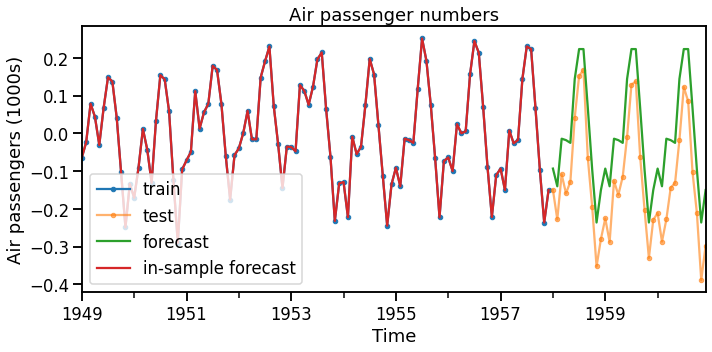

In [36]:
# --- PLOTTING LOG Y-DETRENDED--- #
# Plot the forecast.
fig, ax = plt.subplots(figsize=[10, 5])
# Plot training set.
y_train.loc[:forecast_start_time].plot(ax=ax, marker=".")
# Plot actuals in forecasting horizon.
y_test.plot(ax=ax, marker=".", alpha=0.6)
# Plot forecast.
y_forecast.plot(ax=ax)
# Plot 1 step forecasts in training data.
y_forecast_train.plot(ax=ax)

ax.legend(["train", "test", "forecast", "in-sample forecast"])
ax.set_xlabel("Time")
ax.set_ylabel("Air passengers (1000s)")
ax.set_title("Air passenger numbers")
plt.tight_layout()

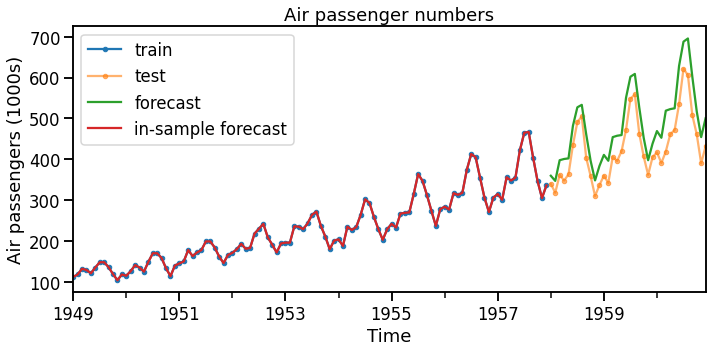

In [37]:
# --- PLOTTING Y--- #

# Plot the forecast.
fig, ax = plt.subplots(figsize=[10, 5])
# Plot training set.
y_train_w_trend.loc[:forecast_start_time].plot(ax=ax, marker=".")
# Plot actuals in forecasting horizon.
y_test_w_trend.plot(ax=ax, marker=".", alpha=0.6)
# Plot forecast.
y_forecast_w_trend.plot(ax=ax)
# Plot 1 step forecasts in training data.
y_forecast_train_w_trend.plot(ax=ax)

ax.legend(["train", "test", "forecast", "in-sample forecast"])
ax.set_xlabel("Time")
ax.set_ylabel("Air passengers (1000s)")
ax.set_title("Air passenger numbers")
plt.tight_layout()

Let's compute the RMSE of this forecast.

In [38]:
# Compute error metrics.
from sklearn.metrics import mean_squared_error

mean_squared_error(
    y_test_w_trend.loc[y_forecast.index], 
    y_forecast_w_trend, 
    squared=False
)

57.27252742098575

We can now do recursive forecasting for tree-based models and adjusting for the trend!

Feel free to change the dates, try different models, and different features!